# GAN

***

Experiment with Generative Adversarial Networks based on [this article](https://realpython.com/generative-adversarial-networks/).

In [30]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt

# For re-usability
torch.manual_seed(111)

### Create the data set for simple y = sin(x) function (x in range [0, 2pi])

In [31]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:,0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:,1] = torch.sin(train_data[:,0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

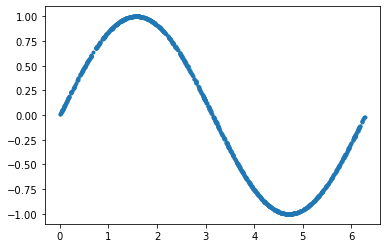

In [32]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [33]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

### Create Discriminator & Generator nets

In [34]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        output = self.model(x)
        return output
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
        
    def forward(self, x):
        output = self.model(x)
        return output

In [35]:
discriminator = Discriminator()
generator = Generator()

### Training the models

In [36]:
lr = 0.001 # learning rate
num_epochs = 300
loss_function = nn.BCELoss()

In [37]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [26]:
for epoch in range(num_epochs):
    for n, (real_samples,_) in enumerate(train_loader):
        # Data for training Discriminator
        real_samples_labels = torch.ones((batch_size, 1)) # 1 for real samples
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)) # 0 for "fake" samples
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # Trainin the Discriminator
        discriminator.zero_grad() # clear the gradients at each step to avoid accumulating them
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward() # calculate the gradients to update weights
        optimizer_discriminator.step() # update discriminator weights
        
        # Data for training Generator
        latent_space_samples = torch.randn((batch_size, 2))
        
        # Training the Generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        
        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.657355010509491 Loss G.: 0.7505490183830261
Epoch: 10 Loss D.: 0.690373957157135 Loss G.: 0.8222972750663757
Epoch: 20 Loss D.: 0.6800248026847839 Loss G.: 1.0879905223846436
Epoch: 30 Loss D.: 0.6096493005752563 Loss G.: 0.8101580739021301
Epoch: 40 Loss D.: 0.7103850245475769 Loss G.: 0.7602136731147766
Epoch: 50 Loss D.: 0.6228328347206116 Loss G.: 0.8047717213630676
Epoch: 60 Loss D.: 0.6702821254730225 Loss G.: 0.8068242073059082
Epoch: 70 Loss D.: 0.6050972938537598 Loss G.: 1.1488230228424072
Epoch: 80 Loss D.: 0.6951301097869873 Loss G.: 0.8065435886383057
Epoch: 90 Loss D.: 0.689238965511322 Loss G.: 0.7050328254699707
Epoch: 100 Loss D.: 0.6759951114654541 Loss G.: 0.7231992483139038
Epoch: 110 Loss D.: 0.51629239320755 Loss G.: 1.4924169778823853
Epoch: 120 Loss D.: 0.6870977282524109 Loss G.: 0.7498778104782104
Epoch: 130 Loss D.: 0.6885086297988892 Loss G.: 0.7616593837738037
Epoch: 140 Loss D.: 0.68923020362854 Loss G.: 0.8642635345458984
Epoch: 150 Lo

### Test the trained generator

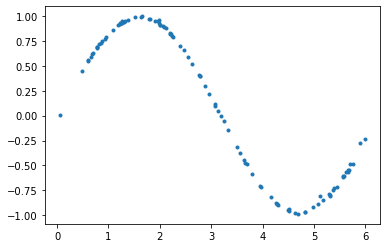

In [27]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

# mnist GAN

***

Now we get messy with images

In [2]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### preparing data

In [7]:
# define a transform function to perform over images
transform = transforms.Compose(
    [
        transforms.ToTensor(), # convert data to PyTorch ternsor
        transforms.Normalize((0.5,), (0.5,)) # convert range of tensor coefficients
    ]
)

In [9]:
# this will download the dataset on current directory!!!
train_set = torchvision.datasets.MNIST(
    root="./data/", train=True, download=True, transform=transform
)

1.1%

31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

81.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



15.2%

100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



112.7%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
# create data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

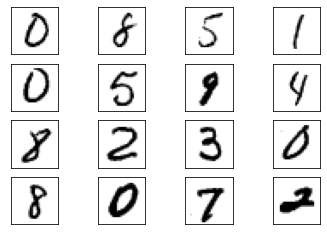

In [11]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(real_samples[i].reshape(28,28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

### Creating Discriminator & Generator

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 784) # convert shape of image tensor to 28x28=784 vector
        output = self.model(x)
        return output
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28) # reconvert to image
        return output

In [15]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

### Training the models

In [16]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
for epoch in range(num_epochs):
    for n, (real_samples,_) in enumerate(train_loader):
        # Data for training Discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # Trainin the Discriminator
        discriminator.zero_grad() # clear the gradients at each step to avoid accumulating them
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward() # calculate the gradients to update weights
        optimizer_discriminator.step() # update discriminator weights
        
        # Data for training Generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        
        # Training the Generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        
        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.012778738513588905 Loss G.: 11.285544395446777
Epoch: 1 Loss D.: 0.007840100675821304 Loss G.: 4.909295082092285
Epoch: 2 Loss D.: 0.07658687233924866 Loss G.: 4.351418972015381
Epoch: 3 Loss D.: 0.13224661350250244 Loss G.: 3.6041040420532227
Epoch: 4 Loss D.: 0.239459827542305 Loss G.: 3.4968008995056152
Epoch: 5 Loss D.: 0.34479472041130066 Loss G.: 1.959396481513977
Epoch: 6 Loss D.: 0.36296290159225464 Loss G.: 2.2809224128723145
Epoch: 7 Loss D.: 0.3738551139831543 Loss G.: 1.4041264057159424
Epoch: 8 Loss D.: 0.45103317499160767 Loss G.: 1.2825595140457153
Epoch: 9 Loss D.: 0.39669907093048096 Loss G.: 1.8873693943023682
Epoch: 10 Loss D.: 0.38669461011886597 Loss G.: 1.388193130493164
Epoch: 11 Loss D.: 0.4949536919593811 Loss G.: 1.274950623512268
Epoch: 12 Loss D.: 0.500879168510437 Loss G.: 1.5403163433074951
Epoch: 13 Loss D.: 0.45211654901504517 Loss G.: 1.207140564918518
Epoch: 14 Loss D.: 0.5676167607307434 Loss G.: 1.2709286212921143
Epoch: 15 Loss D

In [18]:
# Save the weights for reusability
torch.save(discriminator.state_dict(), "./models/gan_mnist_dsc.pt")
torch.save(generator.state_dict(), "./models/gan_mnist_gen.pt")

In [ ]:
# Load the weights from files
discriminator = Discriminator().to(device=device)
discriminator.load_state_dict(torch.load("./models/gan_mnist_dsc.pt"))

generator = Generator().to(device=device)
generator.load_state_dict(torch.load("./models/gan_mnist_gen.pt"))

In [4]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

NameError: name 'batch_size' is not defined